# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
# Uncomment this cell to provide logging output to a file in addition to the lab in the browser
# This also keeps logging if the browser window is closed

# import datetime
# import logging

# nblog = open(f"/content/CryptoCrystalBall/Data/logs/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
# print(nblog)
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

# %autosave 60

In [3]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [4]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-04-17 19:17:39.615783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 19:17:39.697486: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 19:17:39.719907: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-17 19:17:40.192192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

TF Version is 2.10.0, ok!


In [5]:
from tensorflow import keras
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense, Flatten, UnitNormalization, Permute, Conv1D, UpSampling1D, Add, LSTM, Concatenate, Multiply, Activation, Attention, Dropout
from keras.models import Model
from keras.optimizers import Adam

In [6]:
import os
from os import listdir
from os.path import isfile, join

In [7]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc
import random
import datetime

In [8]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [9]:
# Set the checkpoint path for saving train progress
if COLAB:
    raise NotImplementedError("Google Buckets have to be implemented in this notebook before using them in Colab!")
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [10]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

    %cd /content

In [11]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [13]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [14]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [15]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [16]:
# # Define the tick data path
# DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
# print(f"DATA_PATH: {DATA_PATH}")

In [17]:
# # Define the chart image save path
# IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
# print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

In [18]:
# Define a global random seed
RANDOM_SEED = 42

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [19]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator

# For this ML architecture, the X_BLOCK_LENGHT has to be a member of 2**n, otherwise the feature pyramid cannot be built correctly 

# X_BLOCK_LENGHT = 256
X_BLOCK_LENGHT = 128

In [20]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 384 # for X_BLOCK_LENGHT = 256
BATCH_SIZE = 512 # for X_BLOCK_LENGHT = 128

In [21]:
# A fixed number of features is used
FEATURES = 160

In [22]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 7
MIDSPAN = 38
LONGSPAN = 50

In [23]:
INDICATOR_MINMAX_PERIOD = 28

In [24]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": False # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

# Load the dataset

In [25]:
# Define the dataset path
DATASET_PATH = "/content/dataset/ETF/tickdata/ticks"

# Get all file names
ALL_FILES = [os.path.join(DATASET_PATH,f) for f in listdir(DATASET_PATH) if isfile(join(DATASET_PATH, f)) and ".csv" in f ]

# Sort them (as a stable basis for randomizing afterwards)
ALL_FILES = sorted(ALL_FILES)

print(f"The whole dataset contains {len(ALL_FILES)} files.")
print(ALL_FILES[:3])

The whole dataset contains 1064 files.
['/content/dataset/ETF/tickdata/ticks/DE0002635265.csv', '/content/dataset/ETF/tickdata/ticks/DE0002635273.csv', '/content/dataset/ETF/tickdata/ticks/DE0002635281.csv']


### Split the dataset into 3 parts
- The **train** set is used to train the machine-learning network then used to predicting future information
- The **test** set is used in the next step. On it a trading (entry/exit) strategy will be developed
- The **eval** set will then be used as an never-seen set to try and evalutate the combination of the ML network and the trading strategy

In [26]:
# It uses a fixed random seed to allow this cell to be copied to other notebooks producing the same result
SPLIT_RANDOM_SEED = 666

TRAIN_SET_SIZE = 0.5
TEST_SET_SIZE = 0.25
# EVAL_SET_SIZE: The rest

# Files are shuffled before splitting
random.Random(SPLIT_RANDOM_SEED).shuffle(ALL_FILES)

train_split_index = int(len(ALL_FILES) * TRAIN_SET_SIZE)
print(f"train_split_index: {train_split_index}")

test_split_index = int(len(ALL_FILES) * (TRAIN_SET_SIZE + TEST_SET_SIZE))
print(f"test_split_index: {test_split_index}")

TRAIN_FILES = ALL_FILES[:train_split_index]
TEST_FILES = ALL_FILES[train_split_index:test_split_index]
EVAL_FILES = ALL_FILES[test_split_index:]

print(f"The train set contains {len(TRAIN_FILES)} files")
print(f"The test set contains {len(TEST_FILES)} files")
print(f"The eval set contains {len(EVAL_FILES)} files")

train_split_index: 532
test_split_index: 798
The train set contains 532 files
The test set contains 266 files
The eval set contains 266 files


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

As y values for training the ML network the possible future gain and it derivation will be used. The y data type `PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN` will provide both past and future gain, but the model will only be trained on the future gain, as the past gain can be easily calculated directly, also in a live application.

In [27]:
Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_PAST_FUTURE_GAIN)

Y_TYPE_DICT["gain_timespan"] = 60
# Y_TYPE_DICT["direction_ma_timespan"] = 14
# Y_TYPE_DICT["derivation_ma_timespan"] = 14

Y_TYPE_DICT

{'dataType': 3,
 'gain_timespan': 60,
 'direction_ma_timespan': 48,
 'derivation_ma_timespan': 48}

In [28]:
XShape = (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES)
XShape

(512, 128, 160)

In [29]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorSignalsTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = np.min([BATCH_SIZE, 8]),
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y'][:,[1,3]]
    
      # Limit the y signal to avoid excess
      _y /= 10.0
      _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [30]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorSignalsTraining, 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 2)
                                                   )
                                               )

tfGenTraining = tfGenTraining.prefetch(buffer_size=32)
tfGenTraining

2023-04-17 19:17:43.093097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 19:17:43.118534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 19:17:43.118684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 19:17:43.119440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

<PrefetchDataset element_spec=(TensorSpec(shape=(512, 128, 160), dtype=tf.float32, name=None), TensorSpec(shape=(512, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

This approach uses a FPN (Feature-Pyramid-Network, https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c) architecture, followed by LSTM and Dense regressor heads to extract the future gain information.
The pyramid elements are built in a Res-Net style to provide a good information flow.


Additionally, it is equipped with Attention layers to focus on relevant information. Futhermore, it uses antialiasing to smooth out disturbance.


```
Todo: Create Image of network structure
```

In [31]:
# Create the CreateModelFPNWithAttention model
def CreateModelFPNWithAttention():
  # Define model parameters
  mp = {
      "NAME": "FPNWithAttentionBiggerTimebased",
      "VERSION": "2_FutureOnly_60days",
      "CNN_INITIAL_FILTERS": 64,
      "CNN_EXTRACTOR_LAYERS": 6,
      "CNN_INITIAL_KERNEL_SIZE": 2,
      "CNN_MAX_KERNEL_SIZE": 8,
      "FEATURE_PYRAMID_START_INDEX": 2,
      "HEAD_LSTM_SIZE": 64,
      "HEAD_DENSE_SIZE": 32
      }
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, FEATURES), name='inputTicksAndIndicators', dtype='float32')

  # Apply dropout on the input to make the model robust
  inputTicksAndIndicators = Dropout(0.1, name='inputDropout')(inputTicksAndIndicators)

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # ----------------------------------------------------------------------------

  # A 1D-CNN pyramid is used to extract higher-level features out of the time dimension
  conv_layers = []
  aligned_layers = []
  feature_map_layers = []
  anti_aliased_layers = []
  anti_aliased_pyramid_indices = []
  regressor_layers = []

  finalFilters = mp["CNN_INITIAL_FILTERS"] * 2**(mp["FEATURE_PYRAMID_START_INDEX"])
  print(finalFilters) 

  for i in range(mp["CNN_EXTRACTOR_LAYERS"]):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    filters = int(mp["CNN_INITIAL_FILTERS"]*(2**i))
    kernel_size = mp["CNN_INITIAL_KERNEL_SIZE"]*(2**i)
    kernel_size = int(np.min([mp["CNN_MAX_KERNEL_SIZE"], kernel_size]))
    strides = int(np.min([2,kernel_size]))

    print(f"Step {i}, using {filters} filters with a kernel size of {kernel_size} at strides of {strides}")

    # Create the feature extraction convolution
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_1")(source_layer)
    
    res_net_element = Activation("relu",
                              name=f"ResNet_{i}_ReLU")(res_net_element)
    
    res_net_element = Conv1D(filters=source_layer.shape[-1],
                          kernel_size=kernel_size,
                          strides=1, 
                          padding="same",
                          name=f"ResNet_{i}_Conv1D_2")(res_net_element)
    
    res_net_element = Add(name=f"ResNet_{i}_Add")([res_net_element, source_layer])
        
    feature_conv = Conv1D(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides, 
                          padding="same",
                          name=f"ResNet_{i}_Feature_Conv1D_FilterDimReduction")(res_net_element)

    attention_map = Attention(name=f"Attention_Layer_{i}")([feature_conv,feature_conv])
    print(f"attention_map.shape: {attention_map.shape}")

    feature_conv_attentioned = Multiply(name=f"Multiply_Apply_Attention_{i}")([feature_conv, attention_map])
    print(f"feature_conv_attentioned.shape: {feature_conv_attentioned.shape}")
    
    conv_layers.append(feature_conv_attentioned)

    # Apply the feature extraction pyramid
    if mp["FEATURE_PYRAMID_START_INDEX"] <= i:
      # Apply a 1x1 convolution to align the channel depth    
      if feature_conv_attentioned.shape[-1] != finalFilters:
        aligned_layer = Conv1D(filters=finalFilters,
                              kernel_size=1,
                              strides=1,
                              padding="same",
                              name=f"Channel_Depth_Alignment_{i}")(feature_conv_attentioned)
      else:
        aligned_layer = feature_conv_attentioned
      
      aligned_layers.append(aligned_layer)

  # Go top-down through the aligned_layers to create the feature_map_layers
  for i in range(mp["CNN_EXTRACTOR_LAYERS"]-1, mp["FEATURE_PYRAMID_START_INDEX"]-1, -1):
    aligned_layers_index = i - mp["FEATURE_PYRAMID_START_INDEX"]
    aligned_layer = aligned_layers[aligned_layers_index]

    print(f"Building feature_map_layers, step {i}. Shape of aligned_layer: {aligned_layer.shape}")

    # The highest-filtered layer is taken as feature map directly
    if i == mp["CNN_EXTRACTOR_LAYERS"]-1:
      feature_map_layers.append(aligned_layer)
      anti_aliased_layers.append(feature_map_layers[-1])
    else:
      # Take the last feature_map_layer and scale it by two
      upsampled = UpSampling1D(size=2,
                               name=f"Pyramid_Upsampling_{i}")(feature_map_layers[-1])

      # Add the aligned_layer
      added = Add(name=f"Pyramid_Add_{i}")([upsampled, aligned_layer])

      # Append as new feature_map_layer
      feature_map_layers.append(added)

      # Apply a convolution with a kernel size of 3 to "reduce the aliasing effect"
      anti_aliased_layer = Conv1D(filters=feature_map_layers[-1].shape[-1],
                                  kernel_size=3,
                                  strides=1,
                                  padding="same",
                                  name=f"Anti_Alias_{i}")(feature_map_layers[-1])

      anti_aliased_layers.append(anti_aliased_layer)

    # Helper storage to keep pyramid index consistent, also in predictor/regressor
    anti_aliased_pyramid_indices.append(i)

  # Apply the predictor head to each feature dimension layer
  for n in range(len(anti_aliased_layers)):
    predictor_input = anti_aliased_layers[n]

    # Get the pyramid index
    pyramid_index = anti_aliased_pyramid_indices[n]

    # Permute the Conv output back
    predictor_input = Permute((2, 1), name=f"PermutePredictorInput_{pyramid_index}")(predictor_input)

    predictor = LSTM(units=mp["HEAD_LSTM_SIZE"],
                     name=f"Predictor_Head_{pyramid_index}_LSTM")(predictor_input)
    
    # Direction and derivation regressor
    regressor = Dense(units=mp["HEAD_DENSE_SIZE"],
                      name=f"Predictor_Head_{pyramid_index}_Dense_Regressor",
                      activation='relu')(predictor)
    
    regressor_layers.append(regressor)
  
  # Add all regressors together
  regressor_conced = Concatenate(name="Concatenate_regressors")(regressor_layers)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_1")(regressor_conced)
  #regressor_conced = Dense(regressor_conced.shape[1], name="Combined_Regressor_2")(regressor_conced)

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation="tanh", name="Output")(regressor_conced)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name=mp["NAME"] + "_" + str(mp["VERSION"]))

  return model, mp

model, model_config = CreateModelFPNWithAttention()
print(model_config)
model.summary(line_length=220)

256
Step 0, using 64 filters with a kernel size of 2 at strides of 2
attention_map.shape: (None, 64, 64)
feature_conv_attentioned.shape: (None, 64, 64)
Step 1, using 128 filters with a kernel size of 4 at strides of 2
attention_map.shape: (None, 32, 128)
feature_conv_attentioned.shape: (None, 32, 128)
Step 2, using 256 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 16, 256)
feature_conv_attentioned.shape: (None, 16, 256)
Step 3, using 512 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 8, 512)
feature_conv_attentioned.shape: (None, 8, 512)
Step 4, using 1024 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 4, 1024)
feature_conv_attentioned.shape: (None, 4, 1024)
Step 5, using 2048 filters with a kernel size of 8 at strides of 2
attention_map.shape: (None, 2, 2048)
feature_conv_attentioned.shape: (None, 2, 2048)
Building feature_map_layers, step 5. Shape of aligned_layer: (None, 2, 256)
Building feature_

# Train the model

In [32]:
# Define the checkpoint name for storing training progress
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB"
CHKPNT_NAME

'FPNWithAttentionBiggerTimebased_2_FutureOnly_60days_GPU_128LB'

In [33]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [34]:
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = ["mse"], 
    metrics=["mae"])

In [35]:
#@title CustomCallback
# This method stores the model weights every `save_freq` batches, or at least at the epoch's end

class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

#       fp = os.path.join(_save_folder, "c.pickle")
#       with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
#       logging.info(f"Saved optimizer config to '{fp}'")

#       # Save optimizer weights
#       # w = copy.deepcopy(self.model.optimizer.get_weights())

#       fp = os.path.join(_save_folder, "w.pickle")
#       with open(fp, "wb") as handle:
#         # with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
#       logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [36]:
# If the training is resumed from a previous checkpoint, these epochs can be added to keep model saving consistent
epoch_add = 0

In [37]:
# Define how often the model shall be saved
CALLBACK_EVERY_N_BATCHES = 2000

In [38]:
# Create the custom callback
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [39]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [40]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + "_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/CryptoCrystalBall/Data/logs",log_dir.split("/")[-1])

log_dir

'/content/CryptoCrystalBall/Data/logs/FPNWithAttentionBiggerTimebased_2_FutureOnly_60days_GPU_128LB_20230417191744'

In [41]:
# Create a TensorBoard callback for moniting the training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES,
    profile_batch=(5,100)
    )

2023-04-17 19:17:44.505874: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-17 19:17:44.505897: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-17 19:17:44.505932: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-04-17 19:17:44.506115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2023-04-17 19:17:44.596860: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-17 19:17:44.596964: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [42]:
# Load previous weights if necessary
MODEL_PATH = "/content/CryptoCrystalBall/Data/strategies/etf_good_on_test_and_eval/FPNWithAttentionBiggerTimebased_2_FutureOnly_60days_GPU_128LB/cp_daily_valid_05_end/model.h5"

model.load_weights(MODEL_PATH)

# Proof that the PredictionCalculator is working correctly

In [43]:
# Create a generator for prediction
# Todo: Use same method as for training to avoid different settings

def pythonGeneratorPrediction(fileList):
  # Initialize the FileListToDataStream generator
  dataStream = DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = BATCH_SIZE,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStream)
      _X = ne['X']
      _y = np.zeros(ne['y'].shape)
    
      # Limit the y signal to avoid excess
      # _y /= 10.0
      # _y = np.clip(_y, -10.0, 10.0)

      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [44]:
# Load a file to visualize the prediction results
FILE_FOR_PC_PROOF = "/content/CryptoCrystalBall/Data/ETF/tickdata/predicted/wurst/cp_daily_valid_05_end/test/testfile.csv"
FILE_FOR_PC_PROOF

'/content/CryptoCrystalBall/Data/ETF/tickdata/predicted/wurst/cp_daily_valid_05_end/test/testfile.csv'

In [45]:
dfForPCProof = pd.read_csv(FILE_FOR_PC_PROOF)
dfForPCProof.set_index("startsAt", inplace=True)
# dfForPCProof.sort_index(inplace=True)
# dfForPCProof.drop("Unnamed: 0", axis=1, inplace=True)
dfForPCProof

,open,high,low,close,volume,quoteVolume,p_future_gain,p_future_gain_derivation
startsAt,,,,,,,,
1115078400,27.03,27.03,27.03,27.03,0.0,0.0,NaN,NaN
1115164800,27.08,27.08,27.08,27.08,0.0,0.0,NaN,NaN
1115251200,27.38,27.38,27.38,27.38,0.0,0.0,NaN,NaN
1115337600,27.50,27.50,27.50,27.50,0.0,0.0,NaN,NaN
1115424000,27.50,27.50,27.50,27.50,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
1211760000,39.05,39.05,39.05,39.05,0.0,0.0,0.003500,-0.000295
1211846400,38.93,38.93,38.93,38.93,0.0,0.0,0.003413,-0.000211
1211932800,39.30,39.30,39.30,39.30,0.0,0.0,0.003284,0.000032


In [46]:
# 4 times is reuqired as there are triple average indicators (or something like this)
RING_IN_PERIOD = 2 * LONGSPAN
RING_IN_PERIOD

100

In [47]:
# Get a slice of the full DF out
def storeDFSlice(fullDF, slice_start_position):
  # Todo: Check for DF boundaries

  # Crop to match batch size
  sliceDF = fullDF.iloc[slice_start_position:slice_start_position+RING_IN_PERIOD+INDICATOR_MINMAX_PERIOD+X_BLOCK_LENGHT,:]

  # Drop the for the whole DF predicted values
  old_chained_assignment = pd.options.mode.chained_assignment
  pd.options.mode.chained_assignment = None
  # sliceDF.drop(["p_future_gain","p_future_gain_derivation"], axis=1, inplace=True)
  pd.options.mode.chained_assignment = old_chained_assignment

  # Store it
  store_path = "/content/sliceDF.csv" # Todo tmp file
  sliceDF.to_csv(store_path)

  return sliceDF, store_path

In [48]:
# Load a full DF
fullDF = pd.read_csv("/content/CryptoCrystalBall/Data/ETF/tickdata/predicted/wurst/cp_daily_valid_05_end/test/testfile.csv")

In [49]:
s0,_ = storeDFSlice(fullDF,20)
s0.to_csv("/content/s0.csv")
s0

,startsAt,open,high,low,close,volume,quoteVolume,p_future_gain,p_future_gain_derivation
20,1116806400,28.14,28.14,28.14,28.14,0.0,0.0,NaN,NaN
21,1116892800,28.07,28.07,28.07,28.07,0.0,0.0,NaN,NaN
22,1116979200,28.12,28.12,28.12,28.12,0.0,0.0,NaN,NaN
23,1117065600,28.25,28.25,28.25,28.25,0.0,0.0,NaN,NaN
24,1117152000,28.28,28.28,28.28,28.28,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
271,1138492800,34.62,34.62,34.62,34.62,0.0,0.0,0.003682,-0.000694
272,1138579200,34.59,34.59,34.59,34.59,0.0,0.0,0.003945,-0.000694
273,1138665600,34.65,34.65,34.65,34.65,0.0,0.0,0.004268,-0.000521
274,1138752000,35.01,35.01,35.01,35.01,0.0,0.0,0.004228,-0.000872


In [50]:
s1,_ = storeDFSlice(fullDF,21)
s1.to_csv("/content/s1.csv")
s1

,startsAt,open,high,low,close,volume,quoteVolume,p_future_gain,p_future_gain_derivation
21,1116892800,28.07,28.07,28.07,28.07,0.0,0.0,NaN,NaN
22,1116979200,28.12,28.12,28.12,28.12,0.0,0.0,NaN,NaN
23,1117065600,28.25,28.25,28.25,28.25,0.0,0.0,NaN,NaN
24,1117152000,28.28,28.28,28.28,28.28,0.0,0.0,NaN,NaN
25,1117238400,28.28,28.28,28.28,28.28,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272,1138579200,34.59,34.59,34.59,34.59,0.0,0.0,0.003945,-0.000694
273,1138665600,34.65,34.65,34.65,34.65,0.0,0.0,0.004268,-0.000521
274,1138752000,35.01,35.01,35.01,35.01,0.0,0.0,0.004228,-0.000872
275,1138838400,34.63,34.63,34.63,34.63,0.0,0.0,0.004356,-0.001005


In [51]:
# Create a generator for prediction
def pythonGeneratorPrediction(fileList):
    assert 1 == len(fileList) # This gen shall only be used for one file 

    batch_size = INDICATOR_MINMAX_PERIOD+RING_IN_PERIOD

    # Initialize the FileListToDataStream generator
    dataStream = DataStreamCreator.FileListToDataStream(fileList = fileList,
                                                     batch_size = batch_size,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT,
                                                     shuffle=False,
                                                     parallel_generators = 1,
                                                     random_seed = RANDOM_SEED,
                                                     **DATA_STREAM_PARAMETERS
                                                    )

    # This while has to integrated into the FileListToDataStream method
    while True:  
        try:
            ne = next(dataStream)           
            _X = ne['X']
            _y = ne['y']

            # Crop off the indicator ring-in-period and the X-Block period
            _X = _X[-INDICATOR_MINMAX_PERIOD:]          
            
            _y = np.zeros((_X.shape[0],_y.shape[1]))

            yield (_X, _y)
        except StopIteration as si:
            logging.warning("StopIteration in pythonGenerator")
            logging.warning(si)
            return

In [52]:
x0 = next(pythonGeneratorPrediction(["/content/s0.csv"]))[0]
x0.shape

INFO:root:File 's0.csv' loaded, 0 left


(28, 128, 116)

In [53]:
x1 = next(pythonGeneratorPrediction(["/content/s1.csv"]))[0]
x1.shape

INFO:root:File 's1.csv' loaded, 0 left


(28, 128, 116)

In [54]:
x0[1:,:,:].shape

(27, 128, 116)

In [55]:
x1[:-1,:,:].shape

(27, 128, 116)

In [56]:
#x0[1:,:,:] - x1[:-1,:,:]

# XGen

In [57]:
df0 = pd.read_csv("/content/s0.csv")
df0.set_index("startsAt", inplace=True)
xg0 = DataStreamCreator.XBlockGenerator(df0,INDICATOR_MINMAX_PERIOD+RING_IN_PERIOD,X_BLOCK_LENGHT)
x0Gend = next(xg0)
x0Gend.shape

(128, 128, 9)

In [58]:
df1 = pd.read_csv("/content/s1.csv")
df1.set_index("startsAt", inplace=True)
xg1 = DataStreamCreator.XBlockGenerator(df1,INDICATOR_MINMAX_PERIOD+RING_IN_PERIOD,X_BLOCK_LENGHT)
x1Gend = next(xg1)
x1Gend.shape

(128, 128, 9)

In [59]:
np.max(x0Gend[1:,:,:] - x1Gend[:-1,:,:])

0.0

## --> XGen from raw DF are the same!

---
# XGen after IndicatorCalculator

In [60]:
ic = IndicatorCalculator(SHORTSPAN, MIDSPAN, LONGSPAN)

In [61]:
DATA_STREAM_PARAMETERS

{'calcPatternIndicators': False, 'calcVolumeInidators': False, 'dropna': False}

In [62]:
dfI0 = ic.CreateAllIndicatorsTable(df0, **DATA_STREAM_PARAMETERS)
dfI0

,APO_12_26,AROONDOWN38,AROONDOWN50,AROONDOWN7,AROONOSC38,AROONOSC50,AROONOSC7,AROONUP38,AROONUP50,AROONUP7,...,c_WMA50,c_WMA7,close,high,low,open,v_MFI38,v_MFI50,v_MFI7,volume
startsAt,,,,,,,,,,,,,,,,,,,,,
1116806400,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.14,28.14,28.14,28.14,0.0,0.0,0.0,0.0
1116892800,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.07,28.07,28.07,28.07,0.0,0.0,0.0,0.0
1116979200,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.12,28.12,28.12,28.12,0.0,0.0,0.0,0.0
1117065600,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.25,28.25,28.25,28.25,0.0,0.0,0.0,0.0
1117152000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.28,28.28,28.28,28.28,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138492800,-0.101026,26.315789,2.0,28.571429,73.684211,98.0,71.428571,100.000000,100.0,100.000000,...,33.787506,34.324643,34.62,34.62,34.62,34.62,0.0,0.0,0.0,0.0
1138579200,-0.034038,23.684211,0.0,14.285714,73.684211,98.0,71.428571,97.368421,98.0,85.714286,...,33.827859,34.455357,34.59,34.59,34.59,34.59,0.0,0.0,0.0,0.0
1138665600,0.012885,21.052632,0.0,0.000000,78.947368,100.0,100.000000,100.000000,100.0,100.000000,...,33.869004,34.557857,34.65,34.65,34.65,34.65,0.0,0.0,0.0,0.0


In [63]:
dfI1 = ic.CreateAllIndicatorsTable(df1, **DATA_STREAM_PARAMETERS)
dfI1

,APO_12_26,AROONDOWN38,AROONDOWN50,AROONDOWN7,AROONOSC38,AROONOSC50,AROONOSC7,AROONUP38,AROONUP50,AROONUP7,...,c_WMA50,c_WMA7,close,high,low,open,v_MFI38,v_MFI50,v_MFI7,volume
startsAt,,,,,,,,,,,,,,,,,,,,,
1116892800,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.07,28.07,28.07,28.07,0.0,0.0,0.0,0.0
1116979200,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.12,28.12,28.12,28.12,0.0,0.0,0.0,0.0
1117065600,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.25,28.25,28.25,28.25,0.0,0.0,0.0,0.0
1117152000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.28,28.28,28.28,28.28,0.0,0.0,0.0,0.0
1117238400,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,28.28,28.28,28.28,28.28,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138579200,-0.034038,23.684211,0.0,14.285714,73.684211,98.0,71.428571,97.368421,98.0,85.714286,...,33.827859,34.455357,34.59,34.59,34.59,34.59,0.0,0.0,0.0,0.0
1138665600,0.012885,21.052632,0.0,0.000000,78.947368,100.0,100.000000,100.000000,100.0,100.000000,...,33.869004,34.557857,34.65,34.65,34.65,34.65,0.0,0.0,0.0,0.0
1138752000,0.107564,18.421053,2.0,0.000000,81.578947,98.0,100.000000,100.000000,100.0,100.000000,...,33.922729,34.703214,35.01,35.01,35.01,35.01,0.0,0.0,0.0,0.0


In [64]:
dfI0c = dfI0.iloc[(RING_IN_PERIOD):]
dfI0c

,APO_12_26,AROONDOWN38,AROONDOWN50,AROONDOWN7,AROONOSC38,AROONOSC50,AROONOSC7,AROONUP38,AROONUP50,AROONUP7,...,c_WMA50,c_WMA7,close,high,low,open,v_MFI38,v_MFI50,v_MFI7,volume
startsAt,,,,,,,,,,,,,,,,,,,,,
1125446400,-0.188910,94.736842,0.0,71.428571,-50.000000,58.0,-71.428571,44.736842,58.0,0.000000,...,30.555663,30.195714,30.30,30.30,30.30,30.30,0.0,0.0,0.0,0.0
1125532800,-0.195897,92.105263,0.0,57.142857,-50.000000,56.0,42.857143,42.105263,56.0,100.000000,...,30.558643,30.299643,30.61,30.61,30.61,30.61,0.0,0.0,0.0,0.0
1125619200,-0.206474,89.473684,92.0,42.857143,-50.000000,-38.0,42.857143,39.473684,54.0,85.714286,...,30.558031,30.372143,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
1125705600,-0.231346,86.842105,90.0,28.571429,-50.000000,-38.0,42.857143,36.842105,52.0,71.428571,...,30.557169,30.431429,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
1125792000,-0.235385,84.210526,88.0,14.285714,-50.000000,-38.0,42.857143,34.210526,50.0,57.142857,...,30.556016,30.477500,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138492800,-0.101026,26.315789,2.0,28.571429,73.684211,98.0,71.428571,100.000000,100.0,100.000000,...,33.787506,34.324643,34.62,34.62,34.62,34.62,0.0,0.0,0.0,0.0
1138579200,-0.034038,23.684211,0.0,14.285714,73.684211,98.0,71.428571,97.368421,98.0,85.714286,...,33.827859,34.455357,34.59,34.59,34.59,34.59,0.0,0.0,0.0,0.0
1138665600,0.012885,21.052632,0.0,0.000000,78.947368,100.0,100.000000,100.000000,100.0,100.000000,...,33.869004,34.557857,34.65,34.65,34.65,34.65,0.0,0.0,0.0,0.0


In [65]:
dfI1c = dfI1.iloc[(RING_IN_PERIOD):]
dfI1c

,APO_12_26,AROONDOWN38,AROONDOWN50,AROONDOWN7,AROONOSC38,AROONOSC50,AROONOSC7,AROONUP38,AROONUP50,AROONUP7,...,c_WMA50,c_WMA7,close,high,low,open,v_MFI38,v_MFI50,v_MFI7,volume
startsAt,,,,,,,,,,,,,,,,,,,,,
1125532800,-0.195897,92.105263,0.0,57.142857,-50.000000,56.0,42.857143,42.105263,56.0,100.000000,...,30.558643,30.299643,30.61,30.61,30.61,30.61,0.0,0.0,0.0,0.0
1125619200,-0.206474,89.473684,92.0,42.857143,-50.000000,-38.0,42.857143,39.473684,54.0,85.714286,...,30.558031,30.372143,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
1125705600,-0.231346,86.842105,90.0,28.571429,-50.000000,-38.0,42.857143,36.842105,52.0,71.428571,...,30.557169,30.431429,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
1125792000,-0.235385,84.210526,88.0,14.285714,-50.000000,-38.0,42.857143,34.210526,50.0,57.142857,...,30.556016,30.477500,30.53,30.53,30.53,30.53,0.0,0.0,0.0,0.0
1125878400,-0.201603,81.578947,86.0,0.000000,-50.000000,-38.0,100.000000,31.578947,48.0,100.000000,...,30.560847,30.550357,30.69,30.69,30.69,30.69,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138579200,-0.034038,23.684211,0.0,14.285714,73.684211,98.0,71.428571,97.368421,98.0,85.714286,...,33.827859,34.455357,34.59,34.59,34.59,34.59,0.0,0.0,0.0,0.0
1138665600,0.012885,21.052632,0.0,0.000000,78.947368,100.0,100.000000,100.000000,100.0,100.000000,...,33.869004,34.557857,34.65,34.65,34.65,34.65,0.0,0.0,0.0,0.0
1138752000,0.107564,18.421053,2.0,0.000000,81.578947,98.0,100.000000,100.000000,100.0,100.000000,...,33.922729,34.703214,35.01,35.01,35.01,35.01,0.0,0.0,0.0,0.0


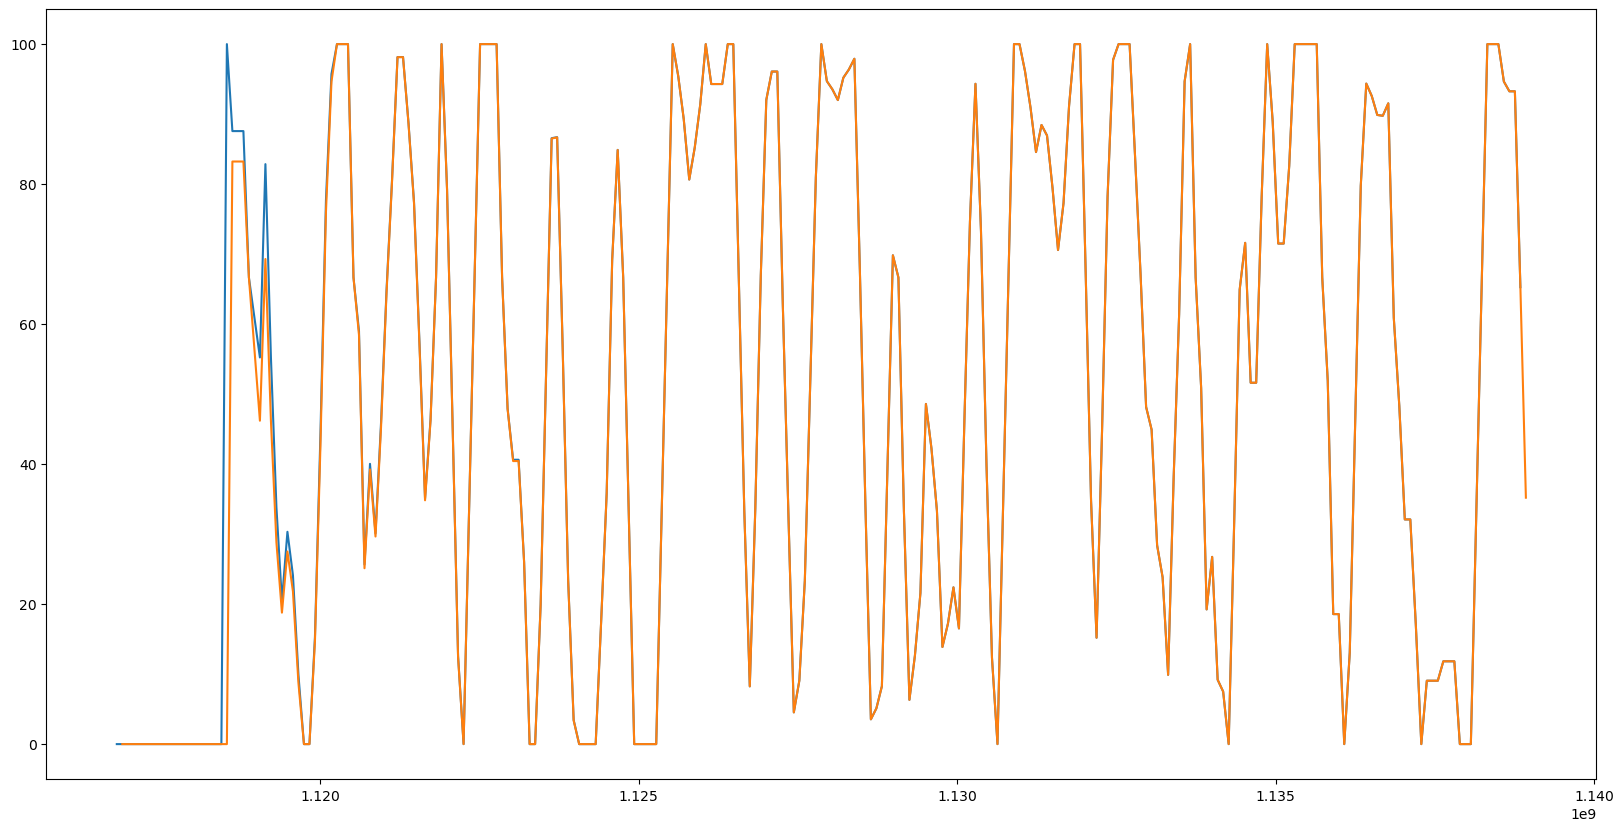

In [66]:
fig, ax1 = plt.subplots(figsize=(20,10))

# x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

# _ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]) / dfI0c["FASTDRSI"])
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]))
_ = ax1.plot(dfI0["FASTDRSI"])
_ = ax1.plot(dfI1["FASTDRSI"])

# ax1.set_ylim(-0.01,0.0)

KeyError: 'RSI50'

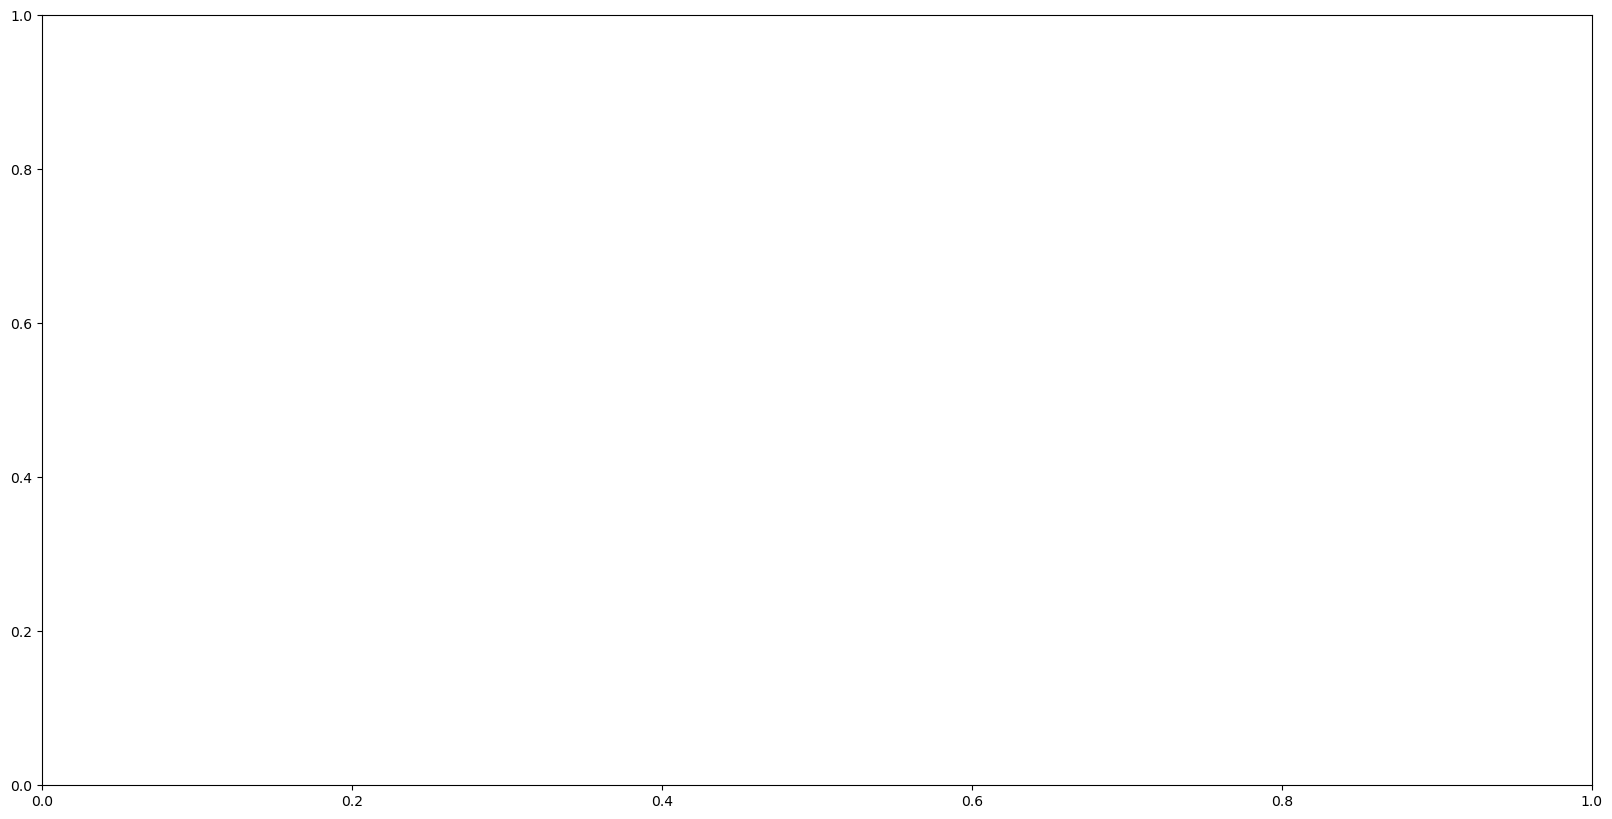

In [67]:
fig, ax1 = plt.subplots(figsize=(20,10))

# x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

# _ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]) / dfI0c["FASTDRSI"])
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]))
_ = ax1.plot(dfI0c.iloc[1:,:]["RSI50"].values)
_ = ax1.plot(dfI1c.iloc[:-1,:]["RSI50"].values)

ax2 = ax1.twinx()

_ = ax2.plot(dfI0c.iloc[1:,:]["RSI50"].values - dfI1c.iloc[:-1,:]["RSI50"].values)

# _ = ax2.plot(dfI1c.iloc[:-1,:]["open"].values)
# ax1.set_ylim(-0.01,0.0)

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))

# x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

# _ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]) / dfI0c["FASTDRSI"])
# _ = ax1.plot((dfI1c["FASTDRSI"] - dfI0c["FASTDRSI"]))
_ = ax1.plot(dfI0c.iloc[1:,:]["DX50"].values / dfI1c.iloc[:-1,:]["DX50"].values)

ax2 = ax1.twinx()

# _ = ax2.plot(dfI1c.iloc[:-1,:]["open"].values)
# ax1.set_ylim(-0.01,0.0)

In [68]:
diffDF = (dfI0c.iloc[1:,:] - dfI1c.iloc[:-1,:]) / np.max(np.abs(dfI0c.iloc[1:,:]))

difflist = []
diffwithname = []

for c in diffDF.columns:
  #print(f"{c}: {np.max(diffDF[c])}")

  difflist.append(np.max(diffDF[c]))
  diffwithname.append(
      [
          c,
          np.max(diffDF[c])
      ]
  )

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [69]:
diffwithname = sorted(diffwithname, key = lambda x: x[1])

In [71]:
for el in diffwithname:
    if 0.001 / 100.0 <= np.abs(el[1]):
        print(f"Indicator '{el[0]}', deviation '{el[1]:.2%}'")

Indicator 'ATR50', deviation '-0.01%'
Indicator 'NATR50', deviation '-0.01%'
Indicator 'ATR38', deviation '-0.00%'
Indicator 'NATR38', deviation '-0.00%'
Indicator 'c_KAMA50', deviation '0.00%'
Indicator 'FASTDRSI', deviation '0.00%'
Indicator 'MACDHIST_12_26_9', deviation '0.01%'
Indicator 'FASTKRSI', deviation '0.01%'


In [ ]:
Indicator 'ATR50', deviation '-0.02%'
Indicator 'CMO38', deviation '0.15%'
Indicator 'DX38', deviation '0.20%'
Indicator 'CMO50', deviation '0.30%'
Indicator 'DX50', deviation '0.34%'
Indicator 'ADX38', deviation '0.97%'
Indicator 'ADX50', deviation '1.18%'
Indicator 'HT_DCPHASE', deviation '3.29%'
Indicator 'ADXR38', deviation '100.00%'
Indicator 'ADXR50', deviation '100.00%'
Indicator 'MINUS_DM50', deviation '-0.02%'
Indicator 'NATR50', deviation '-0.02%'
Indicator 'PLUS_DM50', deviation '-0.02%'
Indicator 'c_HT_TRENDLINE', deviation '0.02%'
Indicator 'RSI38', deviation '0.04%'
Indicator 'PLUS_DI38', deviation '0.05%'
Indicator 'RSI50', deviation '0.09%'
Indicator 'PLUS_DI50', deviation '0.09%'
Indicator 'SINE', deviation '14.80%'
Indicator 'LEADSINE', deviation '17.11%'
Indicator 'c_TEMA38', deviation '96.64%'
Indicator 'c_TEMA50', deviation '98.47%'
Indicator 'TRIX50', deviation '99.12%'
Indicator 'TRIX38', deviation '100.00%'

In [ ]:
plt.plot(difflist)

In [ ]:
# # Load a full DF
# fullDF = pd.read_csv("/content/CryptoCrystalBall/Data/ETF/tickdata/predicted/wurst/cp_daily_valid_05_end/test/testfile.csv")

# Create empty placeholder columns
fullDF.loc[:,"new_p_future_gain"] = np.nan
fullDF.loc[:,"new_p_future_gain_derivation"] = np.nan

# Create some slices
for i in range(1):
  # Get a slice
  _, sliceDFPath = storeDFSlice(fullDF, i)

  # Predict
  with tf.device("CPU:0"):  
    p = model.predict(pythonGeneratorPrediction(fileList=[sliceDFPath]), verbose=1)

  # Start and end index for inserting into the table
  # The start index of the predicted data is at `i` plus: RING_IN_PERIOD (to let the indicators settle) + X_BLOCK_LENGHT (a slice of this size is additionally required to create the first block)
  dfInsertStartIndex = i + RING_IN_PERIOD + X_BLOCK_LENGHT

  # The end index includes also the INDICATOR_MINMAX_PERIOD (the timesteps that have been predicted )
  dfInsertEndIndex = dfInsertStartIndex + INDICATOR_MINMAX_PERIOD

  # Add the prediction to the full table
  fullDF.loc[:,"new_p_future_gain"].values[dfInsertStartIndex:dfInsertEndIndex] = p[:,0]
  fullDF.loc[:,"new_p_future_gain_derivation"].values[dfInsertStartIndex:dfInsertEndIndex] = p[:,1]

In [ ]:
plt.plot(fullDF["p_future_gain"].values[:1000])
plt.plot(fullDF["new_p_future_gain"].values)

In [ ]:
np.nanmax(fullDF["p_future_gain"].values-fullDF["new_p_future_gain"].values)

In [ ]:
with tf.device("CPU:0"):  
  p = model.predict(pythonGeneratorPrediction(fileList=["/content/sliceDF.csv"]), verbose=1)

p.shape

In [ ]:
gtSliceDF = pd.read_csv("/content/CryptoCrystalBall/Data/ETF/tickdata/predicted/wurst/cp_daily_valid_05_end/test/testfile.csv") # dfForPCProof.iloc[slice_start_position:slice_start_position+64+128,:]
gtSliceDF.set_index("startsAt", inplace=True)
gtSliceDF

In [ ]:
# gtSliceDF.loc[:,"p_future_gain"].values[128:]

In [ ]:
plt.plot(p[:,0])
plt.plot(gtSliceDF.loc[:,"p_future_gain"].values[X_BLOCK_LENGHT:X_BLOCK_LENGHT+INDICATOR_MINMAX_PERIOD])


In [ ]:
plt.plot(gtSliceDF.loc[:,"p_future_gain"].values[128:300])
plt.plot(p[:,0])

In [ ]:
stop

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenPrediction = tf.data.Dataset.from_generator(lambda: pythonGeneratorPrediction(fileList=[FILE_FOR_VISUALIZATION]), 
                                               output_types = (tf.float32, tf.float32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                   (BATCH_SIZE, 4)
                                                   )
                                               )
tfGenPrediction

In [ ]:
# Predict something
p = model.predict(tfGenPrediction)
p *= 10.0
p.shape

In [ ]:
# Store the prediction results in nicely named variables
p_future = p[:,0]
p_future_derivation = p[:,1]

In [ ]:
# # Helper method to get the gain data from the past using the generator
# def getPastDataFromGen(genIn, predictedShapeIn):
#     it = genIn.as_numpy_iterator()

#     y_past_data = np.empty((predictedShapeIn[0], 2))
#     i = 0

#     try:
#         while (ne := next(it)):
#             y_past_data[i:i+ne[1].shape[0],0] = ne[1][:,0]
#             y_past_data[i:i+ne[1].shape[0],1] = ne[1][:,2]

#             i += ne[1].shape[0]

#     except StopIteration:
#         pass

#     return y_past_data
    
# y_past_data = getPastDataFromGen(tfGenPrediction, p.shape)
# y_past_data.shape

In [ ]:
# Todo: Improve plotting of the results

In [ ]:
plt.plot(y_past_data[:,0])

In [ ]:
plt.plot(y_past_data[:,1])

In [ ]:
plt.plot(p_future)

In [ ]:
plt.plot(p_future_derivation)

# Add the predictions to the tick table to visualize them

In [ ]:
# Load the table
tickDF = pd.read_csv(FILE_FOR_VISUALIZATION)
tickDF

In [ ]:
# Because the data is cropped in the batching process (Todo: fix this) and can also not be used fully due to the X-Block and y-data creation,
# the loaded DF has a bigger shape
tickDF.shape[0] - p.shape[0]

In [ ]:
# Crop the DF to meet the prediction
tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
tickDFcropped

In [ ]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_future, color="green", label="Predicted p_future")
_ = ax1.plot(p_future_derivation, color="red", label="Predicted p_future_derivation")
# _ = ax1.plot(p_neutral, color="gray", label="Predicted neutral")

ax2 = ax1.twinx()

ax2.plot(tickDFcropped.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Check the signals created by the PredictionCalculator

In [ ]:
# Create the import directories for the PredictionCalculator
pc_dir = '/content/CryptoCrystalBall/SignalGenerator/scripts'
print(f"pc_dir: {pc_dir}")

# Add them to the import paths
sys.path.insert(0, pc_dir)

In [ ]:
from PredictionCalculator import PredictionCalculator

In [ ]:
with tf.device("CPU:0"):
  pc = PredictionCalculator()

In [ ]:
tickDF = pd.read_csv(FILE_FOR_VISUALIZATION)
tickDF.set_index("startsAt", inplace=True)
tickDF.sort_index(inplace=True)
tickDF

In [ ]:
latestSlice = copy.deepcopy(tickDF)
latestSlice 

In [ ]:
preLatestSlice = copy.deepcopy(tickDF).iloc[:-1, :]
preLatestSlice

In [ ]:
pLatest = pc.predict(latestSlice)

In [ ]:
pPreLatest = pc.predict(preLatestSlice)

In [ ]:
pLatest["tickDFlocal"]

In [ ]:
pPreLatest["tickDFlocal"]

In [ ]:
plt.plot(pPreLatest["tickDFlocal"].index - pLatest["tickDFlocal"].index)

In [ ]:
pLatest["X_blocks"][:-1,:,:].shape

In [ ]:
pPreLatest["X_blocks"][1:,:,:].shape

In [ ]:
pLatest["X_blocks"][:-1,:,:] - pPreLatest["X_blocks"][1:,:,:]

In [ ]:
pPreLatest["X_blocks"] - pLatest["X_blocks"]

In [ ]:
plt.plot(pLatest["p_future"])
plt.plot(pPreLatest["p_future"])

In [ ]:
plt.plot(pLatest["X_blocks"][-2,:,11])
plt.plot(pPreLatest["X_blocks"][-1,:,11])

In [ ]:
plt.plot(pLatest["X_blocks"][0,:,11] - pPreLatest["X_blocks"][0,:,11])

In [ ]:
pPreLatest

In [ ]:
pLatest["X_blocks"][-2,0,:]

In [ ]:
pPreLatest["X_blocks"][-1,0,:]

In [ ]:
stop

In [ ]:
#@title Buy and sell signal thresholds
BUY_SIGNAL_THRESHOLD_FUTURE = 0.15 #@param {type:"number"}
BUY_SIGNAL_THRESHOLD_PAST = 0.01 #@param {type:"number"}

SELL_SIGNAL_THRESHOLD_PAST = 0.1 #@param {type:"number"}

In [ ]:
#@title Plot buy and sell signals
chart_name="Buy and sell signals"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name)

x_datetimes = [datetime.datetime.fromtimestamp(ts) for ts in tickDFcropped.loc[:,'open'].index]

_ = ax1.plot(x_datetimes, tickDFcropped.loc[:,'open'].values, color="black", label="Price", linewidth=2)

# Color area axis
ax2 = ax1.twinx()

# Convert the float value prediction into rising and falling categories
yCategoryFall = p_future_gain <= SELL_SIGNAL_THRESHOLD_PAST
yCategoryRise = (p_future_gain > p_past_gain) & (p_past_gain <= BUY_SIGNAL_THRESHOLD_FUTURE) #(p_future_gain >= BUY_SIGNAL_THRESHOLD_FUTURE)

ax2.fill_between(x_datetimes, yCategoryFall , alpha=0.5, color="red", label="'Buy' signal")
ax2.fill_between(x_datetimes, yCategoryRise , alpha=0.5, color="green", label="'Sell' signal")

# Remove tick marks and set limits for color area axis
ax2.set_yticks([])
ax2.set_ylim(-0.05,1.05)

ax3 = ax1.twinx()
_ = ax3.plot(x_datetimes, p_future_gain, color="blue", label="Predicted future gain")
# _ = ax3.plot(x_datetimes, 10.0*p_dir_derivation, color="red", label="10.0 * Predicted price direction derivation")
# ax3.set_ylim(-1.05,1.05)

ax3.plot([np.min(x_datetimes), np.max(x_datetimes)], [0.0,0.0], color="gray")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

# Save the figure
# fig_name = chart_name.replace(" ", "_").replace("'", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

# Add predictions to tick tables
# Predict the test and eval set
The future information for these sets is predicted using the trained model, additionally the past gain info is acquired using the `FileListToDataStream` generator. It is then stored together with the tick information as .csv files, which then can be used to develop a trading strategy.

```
Todo: Add link to finder notebooks
```

In [ ]:
stop

In [ ]:
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/PastFutureGainV2/test"

In [ ]:
# Get the model name and the checkpoint name
model_name, checkpoint_name = tuple(MODEL_PATH.split(os.sep)[-3:-1])
print(f"model_name: '{model_name}'")
print(f"checkpoint_name: '{checkpoint_name}'")

In [ ]:
# Replace the latest element in the DATASET_PATH with "predicted"
prediction_save_path = DATASET_PATH.split(os.sep)[:-1]
prediction_save_path += ["predicted"]

# Preserve the root symbol
if prediction_save_path[0] == "":
    prediction_save_path[0] = os.sep

# Add the model info to the path
prediction_save_path += [model_name, checkpoint_name]
    
prediction_save_path

In [ ]:
# Check each path element and create it if necessary
for i in range(1, len(prediction_save_path)):
    partial_path_string = os.path.join(*prediction_save_path[:i+1])

    if not os.path.exists(partial_path_string):
        os.mkdir(partial_path_string)
        
# Create the test and eval save folders
PREDICTION_SAVE_PATH_TEST = os.path.join(*(prediction_save_path + ["test"]))
if not os.path.exists(PREDICTION_SAVE_PATH_TEST):
    os.mkdir(PREDICTION_SAVE_PATH_TEST)

PREDICTION_SAVE_PATH_EVAL = os.path.join(*(prediction_save_path + ["eval"]))
if not os.path.exists(PREDICTION_SAVE_PATH_EVAL):
    os.mkdir(PREDICTION_SAVE_PATH_EVAL)

print(f"PREDICTION_SAVE_PATH_TEST: '{PREDICTION_SAVE_PATH_TEST}'")
print(f"PREDICTION_SAVE_PATH_EVAL: '{PREDICTION_SAVE_PATH_EVAL}'")

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

fileList = TEST_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_TEST

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenPrediction = tf.data.Dataset.from_generator(lambda: pythonGeneratorPrediction(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenPrediction, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenPrediction, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
# https://stackoverflow.com/questions/52443273/how-do-you-send-arguments-to-a-generator-function-using-tf-data-dataset-from-gen

fileList = EVAL_FILES
PREDICTED_SAVE_PATH = PREDICTION_SAVE_PATH_EVAL

# fileList = TEST_FILES
# PREDICTED_SAVE_PATH = "/content/dataset/etffancy/FPNWithAttentionBiggerTimebased_1_FutureOnly/test"

pd.options.mode.chained_assignment = None  # default='warn'

for file_index in tqdm(range(0, len(fileList))):
    try:
        filename = fileList[file_index]

        logging.info(f"\nFile name: '{filename}' for index {file_index}")

        tfGenPrediction = tf.data.Dataset.from_generator(lambda: pythonGeneratorPrediction(fileList=[filename]), 
                                                       output_types = (tf.float32, tf.float32),
                                                       output_shapes=(
                                                           (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES),
                                                           (BATCH_SIZE, 4)
                                                           )
                                                       )
        p = model.predict(tfGenPrediction, verbose = 0)

        logging.info(f"p.shape: {p.shape}")

        p_future_gain = p[:,0]
        p_future_gain_derivation = p[:,1]
        
        # Load the tick table
        tickDF = pd.read_csv(filename)
        tickDFcropped = tickDF.iloc[-p.shape[0]:, :]
        
        # Add the predicted future gain
        tickDFcropped.loc[:,"p_future_gain"] = p_future_gain
        tickDFcropped.loc[:,"p_future_gain_derivation"] = p_future_gain_derivation
        
        # Get the (known) past data
        y_past_data = getPastDataFromGen(tfGenPrediction, p.shape)

        # Add the past gain
        tickDFcropped.loc[:,"p_past_gain"] = y_past_data[:,0]
        tickDFcropped.loc[:,"p_past_gain_derivation"] = y_past_data[:,1]

        # Save the DF
        tickDFcropped.to_csv(os.path.join(PREDICTED_SAVE_PATH, filename.split(os.path.sep)[-1]))

        logging.info("Saved the predicted data.")
    except KeyboardInterrupt:
        raise
    except Exception as ex:
        logging.warning(str(ex))